# Manga Colorization Model

This model's goal is to colorize manga pages, however, I started from colorization of simple anime-style illustration. 

For training [Anime Sketch Colorization Pair](https://www.kaggle.com/datasets/ktaebum/anime-sketch-colorization-pair/code) dataset was used. 

### Preprocessing
Colored images were converted to grayscale. I have to chose between grayscale and line, and grayscale looks closer to manga style. However, I think the model should be train on some combination of line + grayscale art. 

Images were normalized to [-1, 1] range and resized from 512x512 to 256x256. 

Found 14224 train images and 3539 val images


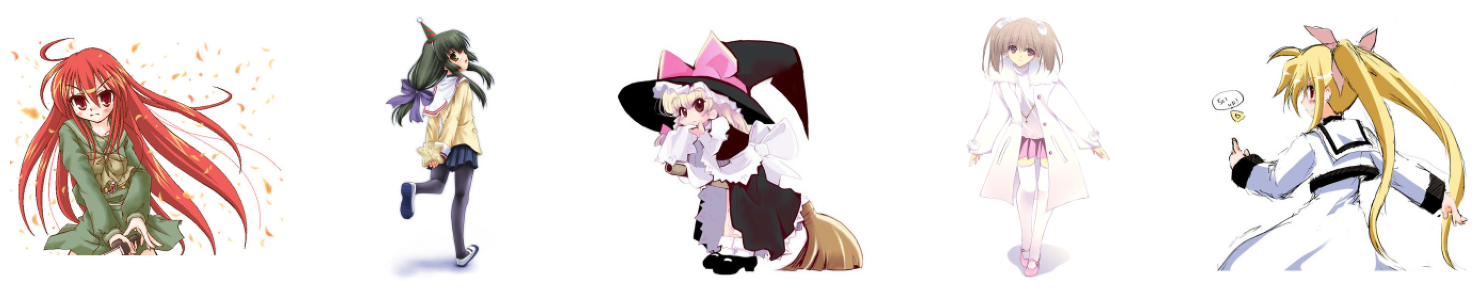

In [2]:
from datasets import SketchDataModule
from utils import show_images
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Import dataset 
batch_size = 5
dataset = SketchDataModule("../images", batch_size=batch_size, resize=(256, 256), out_ch=3)
test_loader = dataset.test_loader

# show images 
gray, color = next(iter(test_loader))
show_images(color)

### The model
Best image generators are trained using Generative Adversarial Network (GAN).
GAN is a model consisting of two neural networks — a generator and a discriminator — that are trained simultaneously in a game-like setup:
- The generator creates fake data (images) from random noise or input sketches.
- The discriminator tries to distinguish between real data and the fake data generated.


### Generator

викреслити нахуй, я не хочу це в своєму гіт хабі
I created several generator architectures that are different from one existing [model](https://huggingface.co/Keiser41/Example_Based_Manga_Colorization). The main difference is that for this model the reference is not needed. 

For model I used pytorch because I am more familiar with this library. 

There are 4 architecures for generator implemented:
1) Simple Unet 
A model with 8 convolutional layers with stride 2 and 8 transposed convolutional layers. There are skip connections between 7 of them.

<img src="images/unet.png" width="400"/>

2) Unet + Self Attention
The same as unet, but there is a trainable attention layer after the last convolutional layer. 

<img src="images/unet_att.png" width="400"/>

3) Unet + Pretrained Feature Extractor 
The same as unet, but there is a frozen Pretrained Feature Extractor. In my case it is resnet50 [model](https://rf5.github.io/2019/07/08/danbuuro-pretrained.html) pretrained on danbooru18 dataset. Extracted features are concatenated with the output of the last convolutional layer.

<img src="images/unet_ext.png" width="400"/>

4) Unet + Attention + Extractor
Unet, where the output of the last conv layer is concatenated with feature extraction model output and then all this 1024 go to self attention layer before transposed conv layers. 

<img src="images/unet_att_ext.png" width="400"/>


In [3]:
from models import ConvBlock, DeconvBlock, SelfAttention, ClassifierFeatureExtractor
import torch.nn as nn

class ColorizationUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=3, use_attention=False, use_extractor=False):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.use_attention = use_attention
        self.use_extractor = use_extractor
        self.down1 = ConvBlock(in_channels, 64, activation='leaky')   # 256 -> 128
        self.down2 = ConvBlock(64, 128, activation='leaky')           # 128 -> 64
        self.down3 = ConvBlock(128, 256, activation='leaky')          # 64 -> 32
        self.down4 = ConvBlock(256, 512, activation='leaky')          # 32 -> 16
        self.down5 = ConvBlock(512, 512, activation='leaky')          # 16 -> 8
        self.down6 = ConvBlock(512, 512, activation='leaky')          # 8 -> 4
        self.down7 = ConvBlock(512, 512, activation='leaky')          # 4 -> 2
        self.down8 = ConvBlock(512, 512, activation='leaky')          # 2 -> 1 (bottleneck)
        if self.use_extractor:
            self.context = ClassifierFeatureExtractor()  
        if self.use_attention:
            self.attn = SelfAttention(512*2 if self.use_extractor else 512) 

        self.up1 = DeconvBlock(512*2 if self.use_extractor else 512, 512, dropout=True)  # 1 -> 2
        self.up2 = DeconvBlock(512*2, 512, dropout=True) # 2 -> 4 
        self.up3 = DeconvBlock(512*2, 512, dropout=True) # 4 -> 8 
        self.up4 = DeconvBlock(512*2, 512)  # 8 -> 16 
        self.up5 = DeconvBlock(512*2, 256)  # 16 -> 32 
        self.up6 = DeconvBlock(256*2, 128)  # 32 -> 64 
        self.up7 = DeconvBlock(128*2, 64)   # 64 -> 128 
        self.up8 = nn.ConvTranspose2d(64*2, out_channels, kernel_size=4, stride=2, padding=1)  # 128->256


    def forward(self, x):
        d1 = self.down1(x)   # -> (64, 128,128)
        d2 = self.down2(d1)  # -> (128, 64,64)
        d3 = self.down3(d2)  # -> (256, 32,32)
        d4 = self.down4(d3)  # -> (512, 16,16)
        d5 = self.down5(d4)  # -> (512, 8,8)
        d6 = self.down6(d5)  # -> (512, 4,4)
        d7 = self.down7(d6)  # -> (512, 2,2)
        d8 = self.down8(d7)  # -> (512, 1,1)
        bottleneck = d8
        if self.use_extractor:
            c = self.context(x)    
            c = c.unsqueeze(2).unsqueeze(3)     
            bottleneck = torch.cat([bottleneck, c], dim=1)  

        if self.use_attention:
            bottleneck = self.attn(bottleneck) 
        u1 = self.up1(bottleneck)               # -> (512, 2,2)
        u1 = torch.cat([u1, d7], dim=1)         # concat skip from down7 (512 -> 1024 ch)
        u2 = self.up2(u1)                       # -> (512, 4,4)
        u2 = torch.cat([u2, d6], dim=1)         # concat skip from down6
        u3 = self.up3(u2)                       # -> (512, 8,8)
        u3 = torch.cat([u3, d5], dim=1)
        u4 = self.up4(u3)                       # -> (512, 16,16)
        u4 = torch.cat([u4, d4], dim=1)
        u5 = self.up5(u4)                       # -> (256, 32,32)
        u5 = torch.cat([u5, d3], dim=1)
        u6 = self.up6(u5)                       # -> (128, 64,64)
        u6 = torch.cat([u6, d2], dim=1)
        u7 = self.up7(u6)                       # -> (64, 128,128)
        u7 = torch.cat([u7, d1], dim=1)
        out = self.up8(u7)                      # -> (3, 256,256)

        out = torch.tanh(out)
        return out

### Discriminator 
Discriminator I built is designed in such a way that it classifies pathes of an image as real/fake. 

<img src="images/discriminator.png" width="400"/>


In [ ]:
import torch.nn.functional as F

class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=1+3): 
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1)   # 256->128
        self.conv2 = ConvBlock(64, 128, kernel_size=4, stride=2, padding=1, activation='leaky')  # 128->64
        self.conv3 = ConvBlock(128, 256, kernel_size=4, stride=2, padding=1, activation='leaky') # 64->32
        self.conv4 = ConvBlock(256, 512, kernel_size=4, stride=2, padding=1, activation='leaky') # 32->16
        self.conv5 = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)  # 16->15 (roughly)
    def forward(self, sketch, color_image):
        x = torch.cat([sketch, color_image], dim=1)  # shpe: (batch, 1+3, 256,256)
        x = F.leaky_relu(self.conv1(x), 0.2, inplace=True)
        x = self.conv2(x)  
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        return x

### Loss Functions
#### Discriminator loss
Discriminator loss function is binary cross-entropy loss because basically it does classification into 2 classes (real/fake).

#### Generator Loss
Generator loss is a combination of discriminator loss, l1 loss (just an average absolute difference between predicted values and ground truth) and optionally perceptual loss. In my model I tried 3 options. 
- only l1 loss + adversarial loss (how many fake pathes discriminator could identify)
- l1 loss + adversarial loss + perceptual loss based on VGG model
- l1 loss + adversarial loss + perceptual loss based on VGG model + small part of perceptual loss based on pretrained on danbooru18 resnet50 model, mentioned above (later refered as "Anime Loss"). 

Perceptual loss measures the difference between high-level feature representations of two images, rather than just comparing pixel values. When VGG perceptual loss is mostly used, I have thought about combining it with 0.1 of difference of feature representation of danbooru18 resnet50 model. 

\begin{gather*}
GeneratorLoss = 0.01 * AdversarialLoss + 1.0 * L1Loss + 0.1 * PerceptualLoss\\
PerceptualLoss = a*VGGLoss + (1-a)*AnimeLoss
\end{gather*}

In [ ]:
from loss import PerceptualLoss
import torchvision.transforms as transforms

class AnimeLoss(nn.Module):
    def __init__(self, a = 0.1):
        super(AnimeLoss, self).__init__()
        self.a = a
        self.device = DEVICE
        model = torch.hub.load('RF5/danbooru-pretrained', 'resnet50')
        model.eval()
        model.to(self.device)
        for param in model.parameters():
            param.requires_grad = False

        self.body = model[0]
        head_layers = list(model[1].children())[:5]  
        self.head = nn.Sequential(*head_layers)

        self.peceptual_loss = PerceptualLoss()

        self.normalize = transforms.Normalize(
            mean=[0.7137, 0.6628, 0.6519],
            std=[0.2970, 0.3017, 0.2979]
        ) 

    def forward(self, output, target):
        if self.a is not 1:
            perceptual_loss = self.peceptual_loss(output, target)
        else:
            perceptual_loss = 0
        
        output = (output + 1) / 2
        target = (target + 1) / 2

        output = F.interpolate(output, size=(360, 360), mode='bilinear', align_corners=False)
        target = F.interpolate(target, size=(360, 360), mode='bilinear', align_corners=False)
        output = torch.stack([self.normalize(img) for img in output])
        target = torch.stack([self.normalize(img) for img in target])

        with torch.no_grad():
            out_f = self.head(self.body(output))
            tgt_f = self.head(self.body(target))

        anime_loss = F.mse_loss(out_f, tgt_f)
    
        return  self.a*anime_loss + (1-self.a)*perceptual_loss

Each model was trained for 50 epochs when it produces more or less reasonable output images. Adam with lr=2e-4 and betas=(0.5, 0.999) was used as optimizer for both discriminator and generator. 

### The results 

#### L1 Loss 

In [4]:
def test_model(model, dataloader):
    model.eval()
    with torch.no_grad():
        for i, (sketch, color) in enumerate(dataloader):
            sketch = sketch.to(DEVICE)
            color = color.to(DEVICE)
            output = model(sketch)
            results = output
    return results

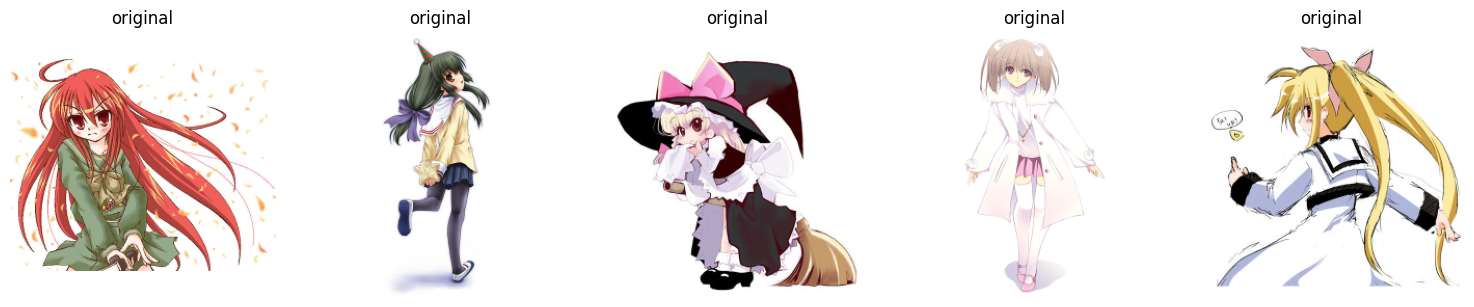

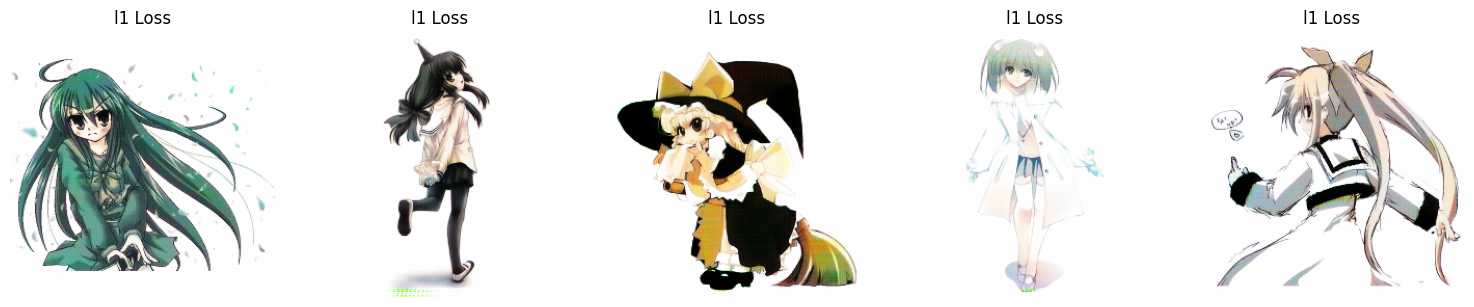

<Figure size 640x480 with 0 Axes>

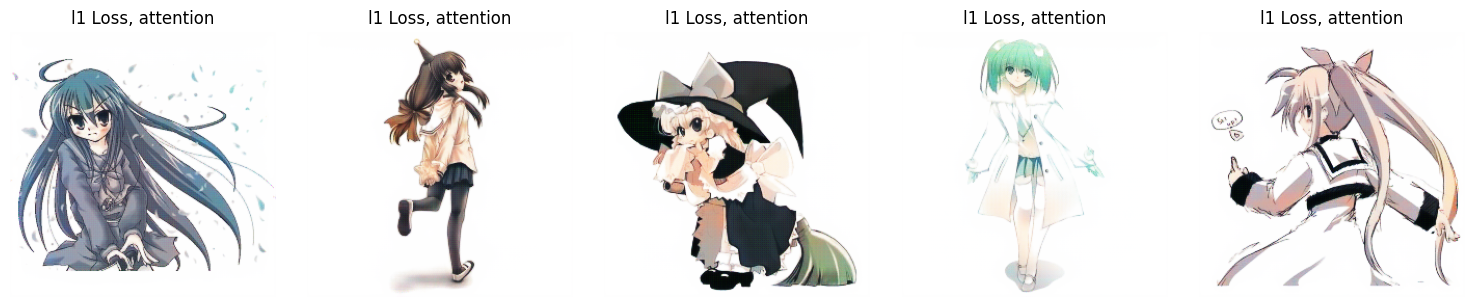

Using cache found in C:\Users\nelia/.cache\torch\hub\RF5_danbooru-pretrained_master


<Figure size 640x480 with 0 Axes>

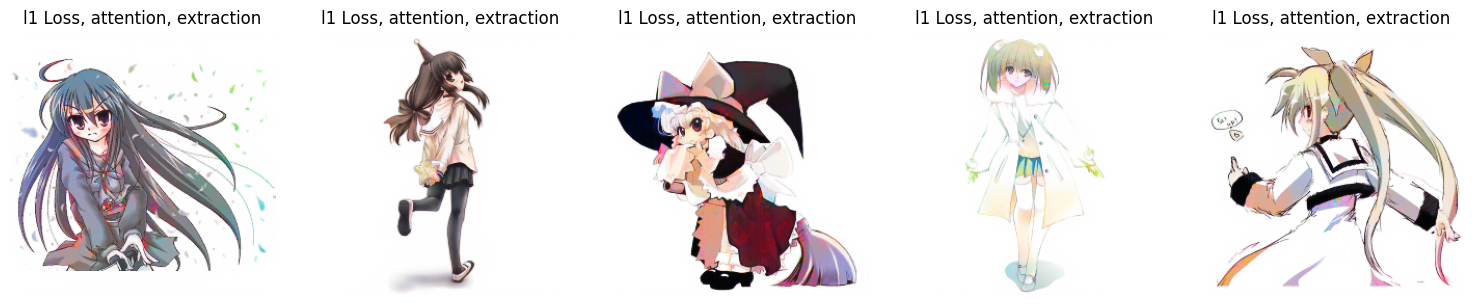

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

show_images(color, titles = ["original"]*5)
# L1 Loss 
model = ColorizationUNet(in_channels=1, out_channels=3, use_attention=False, use_extractor=False).to(DEVICE)
model.load_state_dict(torch.load("../models/l1.pth", map_location=torch.device('cpu')))

preds = test_model(model, test_loader)
show_images(preds, titles = ["l1 Loss"]*5)
plt.clf()

# L1 Loss + attention
model = ColorizationUNet(in_channels=1, out_channels=3, use_attention=True, use_extractor=False).to(DEVICE)
model.load_state_dict(torch.load("../models/att_l1.pth", map_location=torch.device('cpu')))

preds = test_model(model, test_loader)
show_images(preds, titles = ["l1 Loss, attention"]*5)
plt.clf()

# # L1 Loss + feature extractor
# Didn't save the model correctly, so it is not in this file
# model = ColorizationUNet(in_channels=1, out_channels=3, use_attention=False, use_extractor=True).to(DEVICE)
# model.load_state_dict(torch.load("../models/ext_l1.pth", map_location=torch.device('cpu')))

# preds = test_model(model, test_loader)
# show_images(preds, titles = ["l1 Loss, feature extraction"]*5)

# # L1 Loss + attention + feature extractor
model = ColorizationUNet(in_channels=1, out_channels=3, use_attention=True, use_extractor=True).to(DEVICE)
model.load_state_dict(torch.load("../models/att_ext_l1.pth", map_location=torch.device('cpu')))

preds = test_model(model, test_loader)
show_images(preds, titles = ["l1 Loss, attention, extraction"]*5)
plt.clf()


#### Perceptual Loss

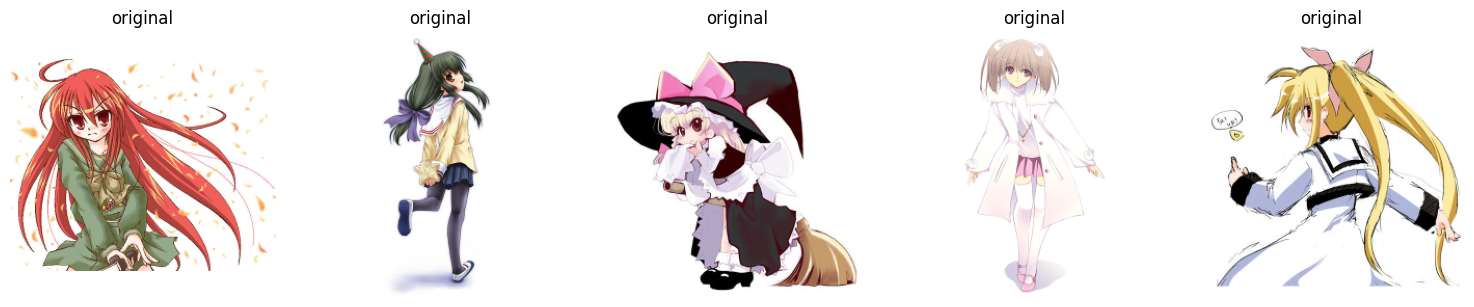

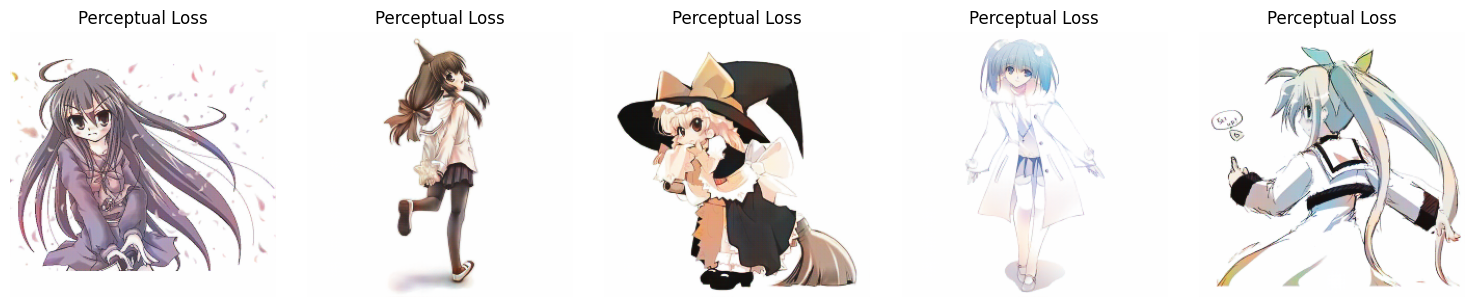

<Figure size 640x480 with 0 Axes>

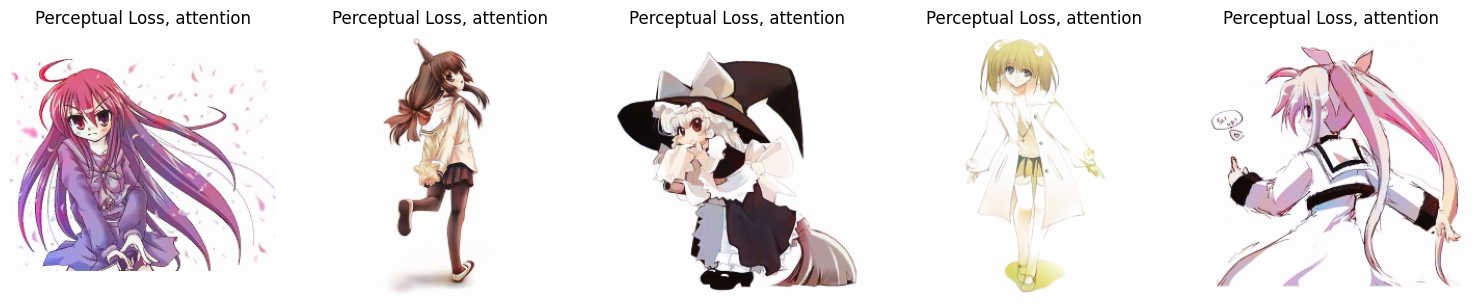

Using cache found in C:\Users\nelia/.cache\torch\hub\RF5_danbooru-pretrained_master


<Figure size 640x480 with 0 Axes>

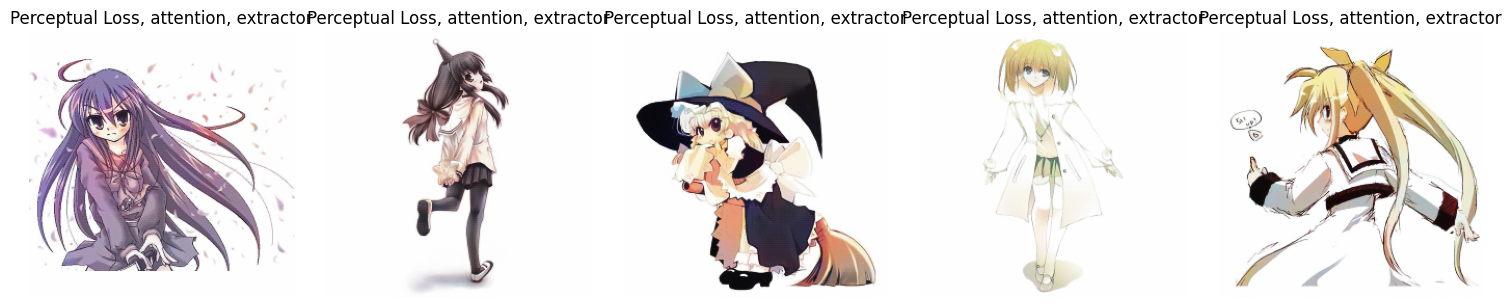

<Figure size 640x480 with 0 Axes>

In [9]:
show_images(color, titles = ["original"]*5)

# Perceptual Loss 
model = ColorizationUNet(in_channels=1, out_channels=3, use_attention=False, use_extractor=False).to(DEVICE)
model.load_state_dict(torch.load("../models/perceptual.pth", map_location=torch.device('cpu')))

preds = test_model(model, test_loader)
show_images(preds, titles = ["Perceptual Loss"]*5)
plt.clf()

# Perceptual Loss + attention
model = ColorizationUNet(in_channels=1, out_channels=3, use_attention=True, use_extractor=False).to(DEVICE)
model.load_state_dict(torch.load("../models/att_perceptual.pth", map_location=torch.device('cpu')))

preds = test_model(model, test_loader)
show_images(preds, titles = ["Perceptual Loss, attention"]*5)
plt.clf()

# Perceptual Loss + feature extractor
# model = ColorizationUNet(in_channels=1, out_channels=3, use_attention=False, use_extractor=True).to(DEVICE)
# model.load_state_dict(torch.load("../models/ext_perceptual.pth", map_location=torch.device('cpu')))

# preds = test_model(model, test_loader)
# show_images(preds, titles = ["Perceptual Loss, extractor"]*5)
# plt.clf()

# Perceptual Loss + attention + feature extractor
model = ColorizationUNet(in_channels=1, out_channels=3, use_attention=True, use_extractor=True).to(DEVICE)
model.load_state_dict(torch.load("../models/att_ext_perceptual.pth", map_location=torch.device('cpu')))

preds = test_model(model, test_loader)
show_images(preds, titles = ["Perceptual Loss, attention, extractor"]*5)
plt.clf()

#### 0.9 Perceptual Loss + 0.1 Anime Loss

In [ ]:
show_images(color, titles = ["original"]*5)

# Anime Loss 
model = ColorizationUNet(in_channels=1, out_channels=3, use_attention=False, use_extractor=False).to(DEVICE)
model.load_state_dict(torch.load("../models/anime.pth", map_location=torch.device('cpu')))

preds = test_model(model, test_loader)
show_images(preds, titles = ["Anime Loss"]*5)
plt.clf()

# Anime Loss + attention
model = ColorizationUNet(in_channels=1, out_channels=3, use_attention=True, use_extractor=False).to(DEVICE)
model.load_state_dict(torch.load("../models/att_anime.pth", map_location=torch.device('cpu')))

preds = test_model(model, test_loader)
show_images(preds, titles = ["Anime Loss, attention"]*5)
plt.clf()

# Anime Loss + feature extractor
model = ColorizationUNet(in_channels=1, out_channels=3, use_attention=False, use_extractor=True).to(DEVICE)
model.load_state_dict(torch.load("../models/ext_anime.pth", map_location=torch.device('cpu')))

preds = test_model(model, test_loader)
show_images(preds, titles = ["Anime Loss, extractor"]*5)
plt.clf()

# Anime Loss + attention + feature extractor
model = ColorizationUNet(in_channels=1, out_channels=3, use_attention=True, use_extractor=True).to(DEVICE)
model.load_state_dict(torch.load("../models/att_ext_anime.pth", map_location=torch.device('cpu')))

preds = test_model(model, test_loader)
show_images(preds, titles = ["Anime Loss, attention, extractor"]*5)
plt.clf()

In [ ]:
# 1.0 Anime Loss + 0*Perceptual Loss
model = ColorizationUNet(in_channels=1, out_channels=3, use_attention=False, use_extractor=False).to(DEVICE)
model.load_state_dict(torch.load("../models/anime.pth", map_location=torch.device('cpu')))

preds = test_model(model, test_loader)
show_images(preds, titles = ["Anime Loss"]*5)
plt.clf()